In [1]:
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from util import *
from load_data import load_input_file, build_combined_input
from tensorflow.keras.losses import binary_crossentropy
from NN_train import *
path_tosave = 'Models/V03_Features'
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = ["DRll01","HT_jets","sumPsbtag","met_met","Mll01","DEtall_SS", "jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [2]:
samples, feature_names, class_names, class_no = load_input_file('data/sstt_multiclass_background_V03.h5', features_to_ignore)
#samples, feature_names, class_names, class_no = load_input_file('data/sstt_V04.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 17 features on the dataset 8 features were loaded: 

DPhill_SS
HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
jet_pt0_nofwd
nJets_OR
randomRunNumber
 
Dataset contains extra labels for different backgrounds!
Class 0  :  679239
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Dataset contains 679239 Signal events and 1425994 Background events.


In [3]:
Number = np.squeeze((input_features[:,-1]).astype(int))
Phi = input_features[:,0]
#Number = np.arange(0,1679947)
feature_names = feature_names[1:-1]
input_features = input_features[:,1:-1]

In [4]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)
print(class_names)
print(class_no)
No_Classes = class_no.max()+1

['signal' 'ttZ' 'tty' 'ttW' 'tttt' 'ttH' 'Other' 'Diboson' 'Fakes']
[0 1 2 3 4 5 6 7 8]


In [5]:
ScaleWeights(targets,weights)
#scale the input between 0-1
scaler = StandardScaler().fit(input_features)
input_scaled = scaler.transform(input_features)


======Weight Statistic========================================
Weights::        W(1)=1200.48, W(0)=2983.69
Scaled weights:: W(1)=1.05262e+06, W(0)=1.05262e+06


In [6]:
def Fold_Odd_Even(input, targets, weights, class_labels, Number, Dphi):
    input_odd = input[Number % 2 == 1]
    targets_odd = targets[Number % 2 == 1]
    weights_odd = weights[Number % 2 == 1]
    class_labels_odd = class_labels[Number % 2 == 1]
    input_even = input[Number % 2 == 0]
    targets_even = targets[Number % 2 == 0]
    weights_even = weights[Number % 2 == 0]
    class_labels_even = class_labels[Number % 2 == 0]
    Dphi_even = Dphi[Number % 2 == 0]
    Dphi_odd = Dphi[Number % 2 == 1]
    return (input_odd, targets_odd, weights_odd, class_labels_odd, Dphi_odd), (input_even, targets_even, weights_even, class_labels_even, Dphi_even)

In [7]:
odd, even = Fold_Odd_Even(input_scaled, targets, weights, class_labels, Number, Phi)

In [8]:
#train, val, test = Train_Val_Test_Split(input_scaled, targets, weights, class_labels)
input_shape = odd[0].shape[1]
n_epochs = 10
batch_size = 1000

In [9]:
def Create_Model_with_Disco(input_shape):
    layer_opts = dict( activation = 'sigmoid', kernel_initializer = initializers.glorot_normal(seed=seed))
    aux_in = Kl.Input(shape = (1,))
    input_layer = Kl.Input(shape = input_shape )
    x = Kl.Dense( 36, **layer_opts) (input_layer)
    x = Kl.Dense( 48, **layer_opts) (x)
    y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
    model = Km.Model(inputs= [input_layer, aux_in], outputs=y_pred)
    model_optimizer = Adam(lr=0.0001)
    custom_loss = lambda  y_true, y_pred: binary_crossentropy(y_true, y_pred) + 10 *calc_dcor2(y_true,y_pred,aux_in,alph=1)
    #model_disco = Loss_Disco(Dphi_and_weight, 0.1)
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=custom_loss, metrics = ['accuracy'])
    model.summary()
    return model

In [10]:
def Train_Odd_Even(odd, even, n_epochs = 400, batch_size = 2000):
    fit_history_list = []
    model_list = []
    input_shape = odd[0].shape[1]

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

    X_odd, X_val_odd, weights_odd, weights_val_odd, y_odd, y_val_odd, Dphi_odd, Dphi_val_odd = train_test_split(odd[0], odd[2], odd[1], odd[4], test_size=0.2)
    X_even, X_val_even, weights_even, weights_val_even, y_even, y_val_even, Dphi_even, Dphi_val_even = train_test_split(even[0], even[2], even[1], even[4], test_size=0.2)
      
    model_odd = Create_Model_with_Disco(input_shape)
    model_even = Create_Model_with_Disco(input_shape)
    #Load Pretrained Model without Disco
    #24_05_2022
    model_odd.load_weights('Models/24_05_2022/weights_odd.h5')
    model_even.load_weights('Models/24_05_2022/weights_even.h5')
    #model_odd.load_weights('Models/V04_new_features/weights_odd.h5')
    #model_even.load_weights('Models/V04_new_features/weights_even.h5')
    
    fit_history_odd = model_odd.fit([X_odd, Dphi_odd], y_odd, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=([X_val_odd,Dphi_val_odd], y_val_odd, weights_val_odd), sample_weight=weights_odd, verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule])
    fit_history_even = model_even.fit([X_even, Dphi_even], y_even, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=([X_val_even,Dphi_val_even], y_val_even, weights_val_even), sample_weight=weights_even, verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule])

    return fit_history_odd, model_odd, fit_history_even, model_even

In [11]:
hist_odd, model_odd, hist_even, model_even = Train_Odd_Even(odd, even, n_epochs = n_epochs, batch_size = batch_size)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 36)           252         input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 48)           1776        dense[0][0]                      
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 3us/sample - loss: 0.6046 - accuracy: 0.7631 - val_loss: 0.5803 - val_accuracy: 0.7456
Epoch 2/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.5759 - accuracy: 0.7645 - val_loss: 0.5494 - val_accuracy: 0.7651
Epoch 3/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.5651 - accuracy: 0.7643 - val_loss: 0.5622 - val_accuracy: 0.7718
Epoch 4/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.5592 - accuracy: 0.7646 - val_loss: 0.5603 - val_accuracy: 0.7784
Epoch 5/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.5605 - accuracy: 0.7662 - val_loss: 0.5537 - val_accuracy: 0.7678
Epoch 6/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.5591 - accuracy: 0.7665 - val_loss: 0.5474 - val_accuracy: 0.7745
Epoch 7/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.5585 - accuracy: 0.7664 - v

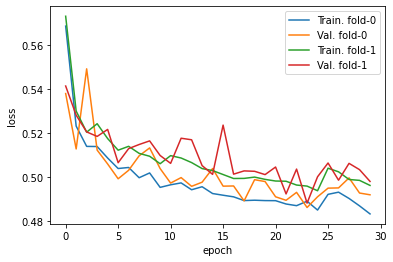

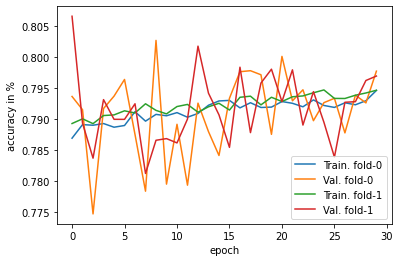

In [12]:
history_list = [hist_odd, hist_even]
Plot_Metrics_KFold(history_list, path_tosave)

In [13]:
Save_Model(model_odd, path_tosave, "_odd")
Save_Model(model_even, path_tosave, "_even")

pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))

Saving architecture to: /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/2ndDiscoModel_V04_Features_Lambda10000/architecture_odd.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/2ndDiscoModel_V04_Features_Lambda10000/weights_odd.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/2ndDiscoModel_V04_Features_Lambda10000/architecture_even.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/2ndDiscoModel_V04_Features_Lambda10000/weights_even.h5


# Evaluation

In [14]:
model_odd = Load_Model(path_tosave, name="_odd")
model_even = Load_Model(path_tosave, name="_even")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/2ndDiscoModel_V04_Features_Lambda10000/architecture_odd.json, /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/2ndDiscoModel_V04_Features_Lambda10000/weights_odd.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/2ndDiscoModel_V04_Features_Lambda10000/architecture_even.json, /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/2ndDiscoModel_V04_Features_Lambda10000/weights_even.h5)


In [15]:
def Plot_NN_Output(model, train, test, path_tosave, log=True):
    nn_scores_test = model.predict([test[0],test[4]], verbose = True)
    nn_scores = model.predict([train[0],train[4]], verbose = True)
    fig = plt.figure()
    plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
    plt.xlabel("NN output", horizontalalignment='right', x=1)
    plt.xlim([0,1])
    plt.ylabel("Density")
    if log == True:
        plt.yscale('log')
    histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
    plt.hist(nn_scores_test[test[1]==1],label = "Test_Signal", **histargs, weights=test[2][test[1]==1])
    plt.hist(nn_scores_test[test[1]==0],label = "Test_Background", **histargs, weights=test[2][test[1]==0])
    plt.hist(nn_scores[train[1]==1],label = "Train_Signal", **histargs, weights=train[2][train[1]==1])
    plt.hist(nn_scores[train[1]==0],label = "Train_Background", **histargs, weights=train[2][train[1]==0])
    plt.legend(loc='upper center', frameon=False,)
    saveit = "{}/{}".format(path_tosave, "DNN_Output.png")
    plt.savefig(saveit)

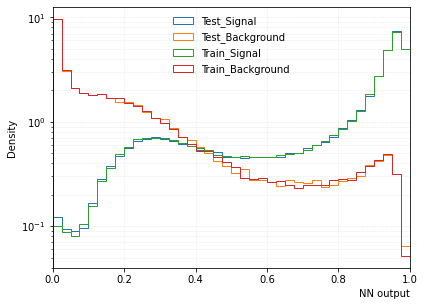

In [16]:
plt.rcParams["figure.figsize"] = (6.4,4.8)
Plot_NN_Output(model_odd, odd, even, path_tosave, True)

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


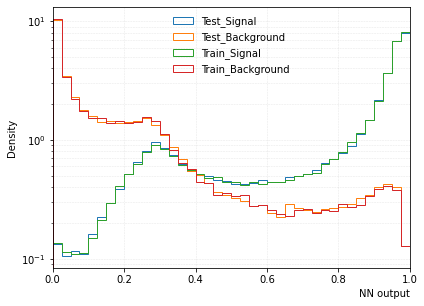

In [17]:
Plot_NN_Output(model_even, even, odd, path_tosave, True)

In [12]:
Background_Odd = odd[0][odd[1]==0]
Background_Even = even[0][even[1]==0]
Background_Odd_Dphi = odd[4][odd[1]==0]
Background_Even_Dphi = even[4][even[1]==0]
Signal_Odd = odd[0][odd[1]==1]
Signal_Even = even[0][even[1]==1]
Signal_Odd_Dphi = odd[4][odd[1]==1]
Signal_Even_Dphi = even[4][even[1]==1]

In [13]:
Signal_NN_out_odd = model_even.predict([Signal_Odd, Signal_Odd_Dphi])
Signal_NN_out_even = model_odd.predict([Signal_Even, Signal_Even_Dphi])
NN_out_Signal = np.squeeze(np.vstack([Signal_NN_out_odd, Signal_NN_out_even]))
DPhi_Signal = np.concatenate([Signal_Odd_Dphi, Signal_Even_Dphi])
NN_out_odd = model_even.predict([Background_Odd, Background_Odd_Dphi])
NN_out_even = model_odd.predict([Background_Even, Background_Even_Dphi])
NN_out_bck = np.squeeze(np.vstack([NN_out_odd, NN_out_even]))
DPhi_bck = np.concatenate([Background_Odd_Dphi, Background_Even_Dphi])

In [14]:
def Calc_Bin_Center(bins):
    bin_centers = np.zeros([bins.size-1])
    for i in range(bins.size-1):
        bin_centers[i] = (bins[i] + bins[i+1])/2
    return bin_centers

FileNotFoundError: [Errno 2] No such file or directory: 'Models/V03_Features/Background_compare.pdf'

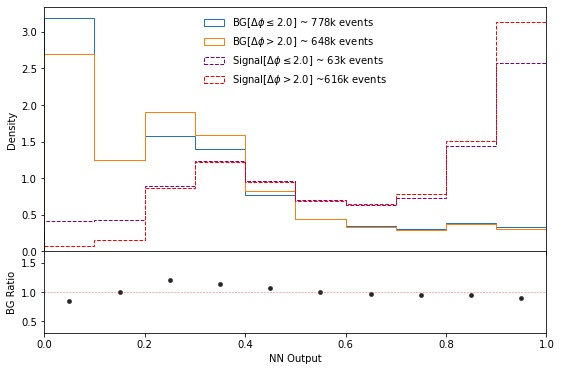

In [15]:
Dphi_Cut = 2.0

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(9,6), gridspec_kw={'height_ratios': [3, 1]})
histargs = {"bins":10, "range":(0,1.), "density":True, "histtype":'step'}
list0 = axs[0].hist(NN_out_bck[DPhi_bck <= Dphi_Cut], label=r"BG$[\Delta \phi \leq 2.0]$ ~ "+str(int(np.round(NN_out_bck[DPhi_bck <= Dphi_Cut].size/1000))) + "k events", **histargs)
list1 = axs[0].hist(NN_out_bck[DPhi_bck > Dphi_Cut], label=r"BG$[\Delta \phi > 2.0]$ ~ "+str(int(np.round(NN_out_bck[DPhi_bck > Dphi_Cut].size/1000))) + "k events", **histargs)
#axs[0].hist(NN_out_bck, label=r"Full Background", **histargs, linestyle="--")
list2 = axs[0].hist(NN_out_Signal[DPhi_Signal <= Dphi_Cut], label=r"Signal$[\Delta \phi \leq 2.0]$ ~ "+str(int(np.round(NN_out_Signal[DPhi_Signal <= Dphi_Cut].size/1000))) + "k events", **histargs, color='purple', linestyle="--")
list3 = axs[0].hist(NN_out_Signal[DPhi_Signal > Dphi_Cut], label=r"Signal$[\Delta \phi > 2.0]$ ~" +str(int(np.round(NN_out_Signal[DPhi_Signal > Dphi_Cut].size/1000))) + "k events", **histargs, color='red', linestyle="--")
bin_centers = Calc_Bin_Center(list0[1])
#xs[0].set_yscale('log')
axs[0].set_ylabel("Density")
#axs[0].set_xlabel(r"NN Output")
axs[0].legend(frameon=False, loc='upper center')
Frac = list1[0]/list0[0]
axs[1].scatter(bin_centers, Frac, marker='.', linewidth=2, color='black', alpha=0.7)
axs[1].set_ylabel(r"BG Ratio")
axs[1].set_ylim(0.3,1.7)
axs[1].hlines(1, -0.1, 1.1, alpha=0.5, linestyle='--', color='red', linewidth=0.6)
#axs[1].grid()
plt.subplots_adjust(hspace=0)
plt.xlim(0,1)
plt.xlabel(r"NN Output")
plt.savefig(path_tosave + '/Background_compare.pdf')

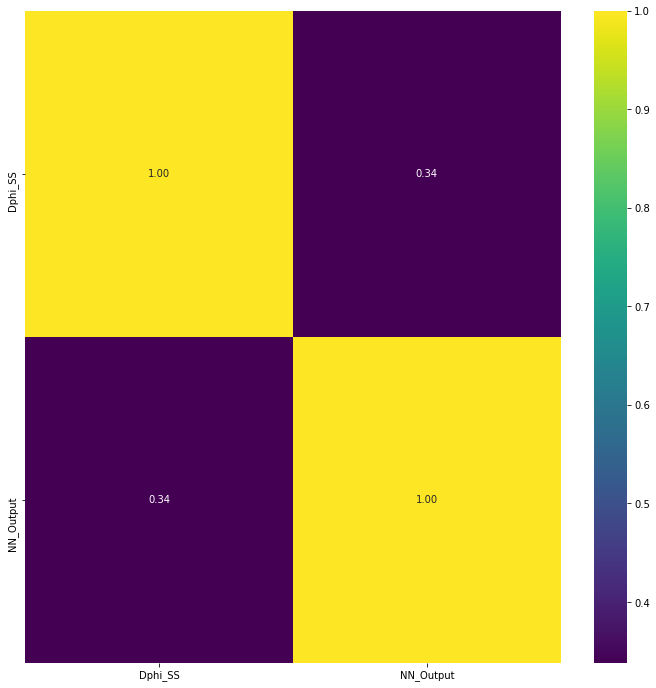

In [25]:
output = np.squeeze(model_even.predict([odd[0],odd[4]]))
corr_mat = np.corrcoef(np.vstack([odd[4], output]).T, None, False)
plt.rcParams["figure.figsize"] = (12,12)
test = sns.heatmap(corr_mat, annot=True, cmap="viridis", xticklabels=["Dphi_SS", "NN_Output"], yticklabels=["Dphi_SS", "NN_Output"], fmt=".2f")

plt.savefig(path_tosave+"/Corr_Dphi_NNout.png")

## Search for best lamda value

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 36)           252         input_6[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 48)           1776        dense_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 4us/sample - loss: 0.3300 - accuracy: 0.8377 - val_loss: 0.3295 - val_accuracy: 0.8426
Epoch 2/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.3290 - accuracy: 0.8381 - val_loss: 0.3334 - val_accuracy: 0.8317
Epoch 3/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.3281 - accuracy: 0.8387 - val_loss: 0.3277 - val_accuracy: 0.8388
Epoch 4/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.3277 - accuracy: 0.8387 - val_loss: 0.3284 - val_accuracy: 0.8425
Epoch 5/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.3275 - accuracy: 0.8386 - val_loss: 0.3291 - val_accuracy: 0.8425
Epoch 6/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.3270 - accuracy: 0.8388 - val_loss: 0.3292 - val_accuracy: 0.8393
Epoch 7/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.3270 - accuracy: 0.8387 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 3us/sample - loss: 0.4209 - accuracy: 0.8167 - val_loss: 0.4146 - val_accuracy: 0.8164
Epoch 2/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.4139 - accuracy: 0.8124 - val_loss: 0.4114 - val_accuracy: 0.8132
Epoch 3/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.4104 - accuracy: 0.8113 - val_loss: 0.4097 - val_accuracy: 0.8128
Epoch 4/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.4086 - accuracy: 0.8100 - val_loss: 0.4080 - val_accuracy: 0.8176
Epoch 5/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.4085 - accuracy: 0.8097 - val_loss: 0.4094 - val_accuracy: 0.8164
Epoch 6/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.4071 - accuracy: 0.8099 - val_loss: 0.4100 - val_accuracy: 0.8093
Epoch 7/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.4066 - accuracy: 0.8091 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 4us/sample - loss: 0.5293 - accuracy: 0.7742 - val_loss: 0.5108 - val_accuracy: 0.7730
Epoch 2/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.5075 - accuracy: 0.7725 - val_loss: 0.5059 - val_accuracy: 0.7803
Epoch 3/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.5004 - accuracy: 0.7732 - val_loss: 0.5038 - val_accuracy: 0.7758
Epoch 4/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.4996 - accuracy: 0.7742 - val_loss: 0.5071 - val_accuracy: 0.7766
Epoch 5/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.4982 - accuracy: 0.7722 - val_loss: 0.5015 - val_accuracy: 0.7759
Epoch 6/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.4955 - accuracy: 0.7734 - val_loss: 0.5039 - val_accuracy: 0.7737
Epoch 7/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.4944 - accuracy: 0.7739 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 4us/sample - loss: 0.6090 - accuracy: 0.7630 - val_loss: 0.5917 - val_accuracy: 0.7752
Epoch 2/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.5739 - accuracy: 0.7661 - val_loss: 0.5502 - val_accuracy: 0.7671
Epoch 3/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.5659 - accuracy: 0.7662 - val_loss: 0.5545 - val_accuracy: 0.7661
Epoch 4/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.5621 - accuracy: 0.7650 - val_loss: 0.5548 - val_accuracy: 0.7615
Epoch 5/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.5580 - accuracy: 0.7659 - val_loss: 0.5449 - val_accuracy: 0.7613
Epoch 6/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.5549 - accuracy: 0.7647 - val_loss: 0.5440 - val_accuracy: 0.7626
Epoch 7/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.5553 - accuracy: 0.7653 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 4us/sample - loss: 0.7422 - accuracy: 0.7549 - val_loss: 0.6804 - val_accuracy: 0.7513
Epoch 2/10
857245/857245 [==============================] - 3s 3us/sample - loss: 0.6710 - accuracy: 0.7622 - val_loss: 0.6652 - val_accuracy: 0.7607
Epoch 3/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.6686 - accuracy: 0.7622 - val_loss: 0.6602 - val_accuracy: 0.7621
Epoch 4/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.6549 - accuracy: 0.7661 - val_loss: 0.6537 - val_accuracy: 0.7713
Epoch 5/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.6511 - accuracy: 0.7669 - val_loss: 0.6489 - val_accuracy: 0.7606
Epoch 6/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.6523 - accuracy: 0.7678 - val_loss: 0.6522 - val_accuracy: 0.7621
Epoch 7/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.6512 - accuracy: 0.7661 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 4us/sample - loss: 0.8646 - accuracy: 0.7529 - val_loss: 0.7734 - val_accuracy: 0.7710
Epoch 2/10
857245/857245 [==============================] - 3s 3us/sample - loss: 0.7792 - accuracy: 0.7656 - val_loss: 0.7555 - val_accuracy: 0.7713
Epoch 3/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.7508 - accuracy: 0.7641 - val_loss: 0.7269 - val_accuracy: 0.7624
Epoch 4/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.7468 - accuracy: 0.7636 - val_loss: 0.7327 - val_accuracy: 0.7563
Epoch 5/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.7326 - accuracy: 0.7636 - val_loss: 0.7433 - val_accuracy: 0.7577
Epoch 6/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.7294 - accuracy: 0.7666 - val_loss: 0.7371 - val_accuracy: 0.7677
Epoch 7/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.7365 - accuracy: 0.7667 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 4us/sample - loss: 0.9642 - accuracy: 0.7494 - val_loss: 0.8653 - val_accuracy: 0.7588
Epoch 2/10
857245/857245 [==============================] - 3s 3us/sample - loss: 0.8476 - accuracy: 0.7602 - val_loss: 0.8104 - val_accuracy: 0.7649
Epoch 3/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.8284 - accuracy: 0.7653 - val_loss: 0.8356 - val_accuracy: 0.7687
Epoch 4/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.8180 - accuracy: 0.7638 - val_loss: 0.8062 - val_accuracy: 0.7636
Epoch 5/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.8067 - accuracy: 0.7606 - val_loss: 0.8309 - val_accuracy: 0.7627
Epoch 6/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.8117 - accuracy: 0.7616 - val_loss: 0.8075 - val_accuracy: 0.7657
Epoch 7/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.8059 - accuracy: 0.7636 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 4us/sample - loss: 1.0374 - accuracy: 0.7508 - val_loss: 0.9386 - val_accuracy: 0.7691
Epoch 2/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.9428 - accuracy: 0.7640 - val_loss: 0.9221 - val_accuracy: 0.7544
Epoch 3/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.8984 - accuracy: 0.7632 - val_loss: 0.8923 - val_accuracy: 0.7657
Epoch 4/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.8821 - accuracy: 0.7609 - val_loss: 0.9007 - val_accuracy: 0.7593
Epoch 5/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.8672 - accuracy: 0.7542 - val_loss: 0.8664 - val_accuracy: 0.7533
Epoch 6/10
857245/857245 [==============================] - 2s 3us/sample - loss: 0.8734 - accuracy: 0.7535 - val_loss: 0.8438 - val_accuracy: 0.7598
Epoch 7/10
857245/857245 [==============================] - 2s 2us/sample - loss: 0.8733 - accuracy: 0.7669 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 3s 4us/sample - loss: 1.2560 - accuracy: 0.7433 - val_loss: 1.1232 - val_accuracy: 0.7427
Epoch 2/10
857245/857245 [==============================] - 2s 3us/sample - loss: 1.0982 - accuracy: 0.7463 - val_loss: 1.0597 - val_accuracy: 0.7508
Epoch 3/10
857245/857245 [==============================] - 2s 3us/sample - loss: 1.0344 - accuracy: 0.7486 - val_loss: 1.0520 - val_accuracy: 0.7473
Epoch 4/10
857245/857245 [==============================] - 2s 3us/sample - loss: 1.0565 - accuracy: 0.7509 - val_loss: 1.0395 - val_accuracy: 0.7527
Epoch 5/10
857245/857245 [==============================] - 2s 3us/sample - loss: 1.0473 - accuracy: 0.7566 - val_loss: 1.0001 - val_accuracy: 0.7506
Epoch 6/10
857245/857245 [==============================] - 2s 3us/sample - loss: 1.0231 - accuracy: 0.7542 - val_loss: 1.0045 - val_accuracy: 0.7513
Epoch 7/10
857245/857245 [==============================] - 3s 3us/sample - loss: 1.0232 - accuracy: 0.7519 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 36)           252         input_42[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 48)           1776        dense_40[0][0]                   
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 1)]          0                                            
___________________________________________________________________________________________

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


857245/857245 [==============================] - 4s 4us/sample - loss: 1.4819 - accuracy: 0.7469 - val_loss: 1.2198 - val_accuracy: 0.7467
Epoch 2/10
857245/857245 [==============================] - 3s 3us/sample - loss: 1.2339 - accuracy: 0.7460 - val_loss: 1.2714 - val_accuracy: 0.7419
Epoch 3/10
857245/857245 [==============================] - 2s 3us/sample - loss: 1.1997 - accuracy: 0.7431 - val_loss: 1.1595 - val_accuracy: 0.7356
Epoch 4/10
857245/857245 [==============================] - 2s 3us/sample - loss: 1.2005 - accuracy: 0.7437 - val_loss: 1.1551 - val_accuracy: 0.7426
Epoch 5/10
857245/857245 [==============================] - 3s 3us/sample - loss: 1.1955 - accuracy: 0.7484 - val_loss: 1.1573 - val_accuracy: 0.7506
Epoch 6/10
857245/857245 [==============================] - 2s 3us/sample - loss: 1.1594 - accuracy: 0.7457 - val_loss: 1.1454 - val_accuracy: 0.7456
Epoch 7/10
857245/857245 [==============================] - 2s 3us/sample - loss: 1.1899 - accuracy: 0.7395 - v

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


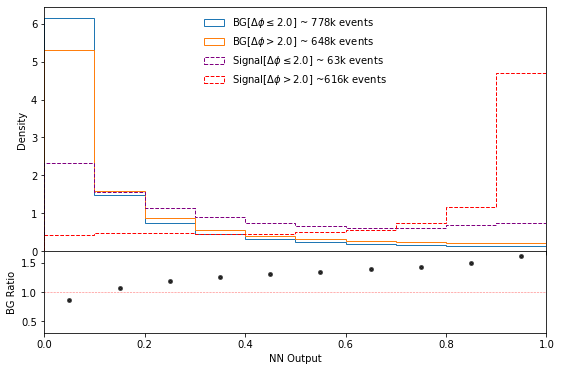

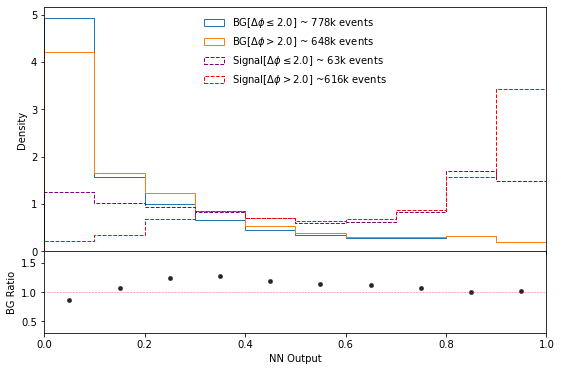

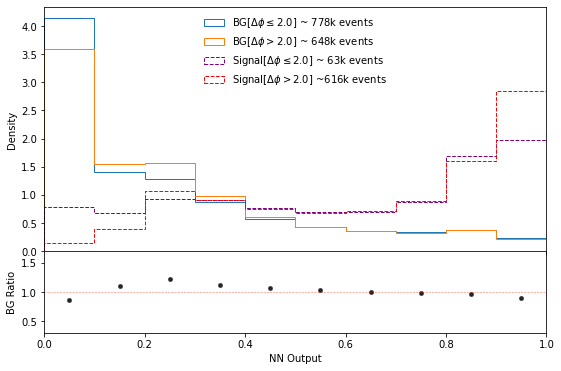

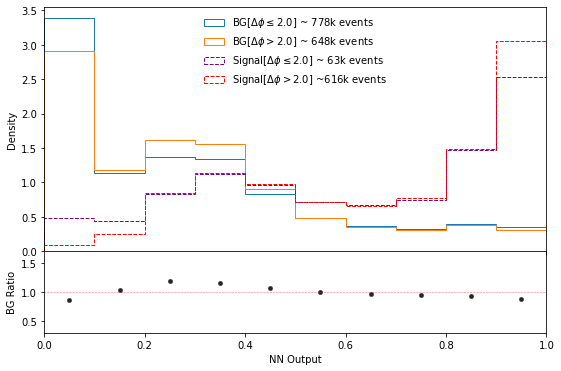

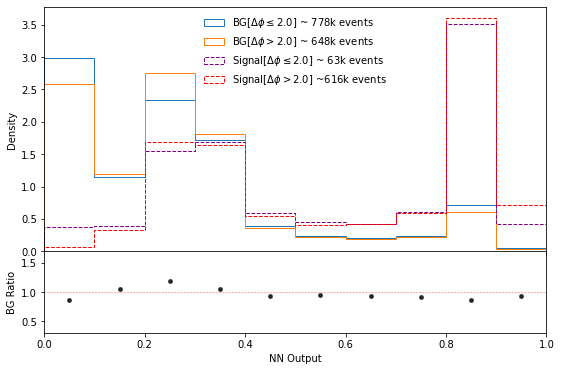

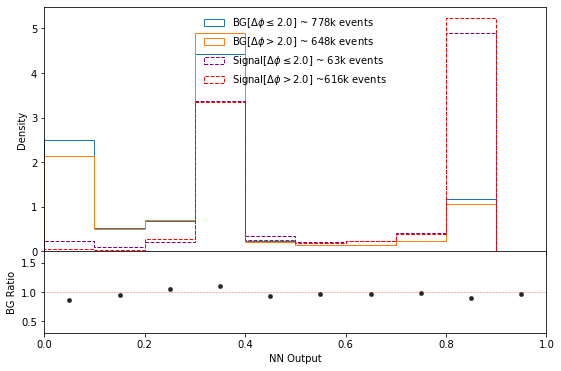

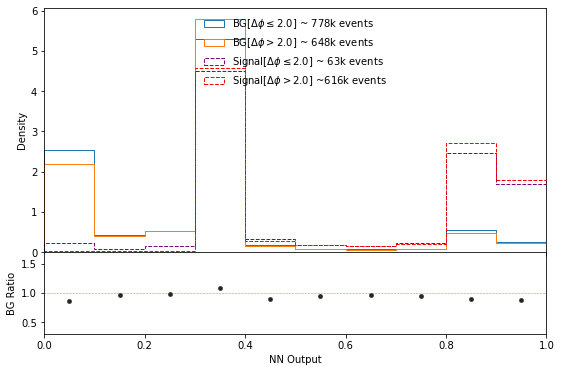

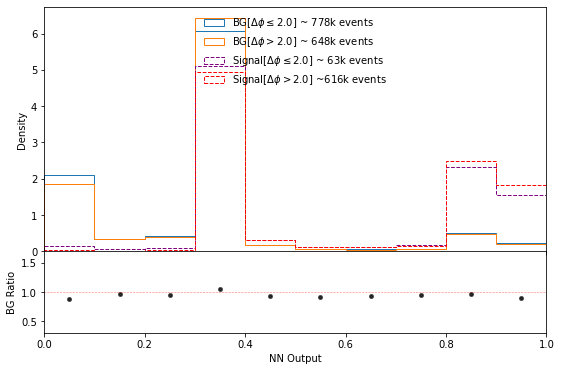

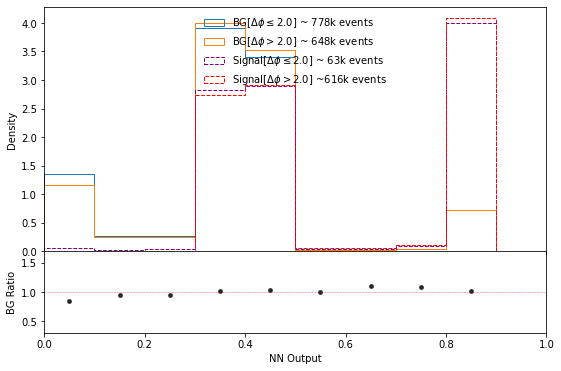

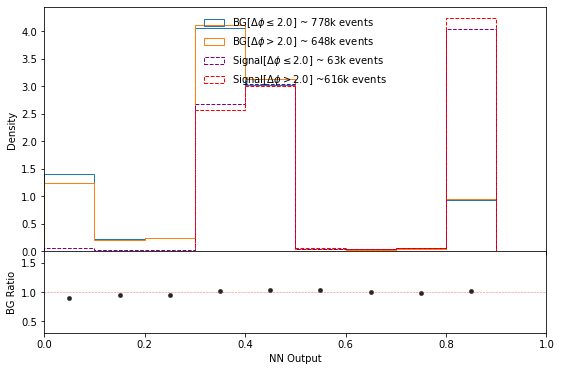

In [16]:
from sklearn.metrics import roc_auc_score,roc_curve, auc,accuracy_score
import uncertainties.unumpy as unp

corr_list = []
AUC_list = []
lambda_list = [0.1, 1, 5, 10, 20, 30, 40, 50, 75, 100]
for lamb in lambda_list:
    def Create_Model_with_Disco(input_shape):
        layer_opts = dict( activation = 'sigmoid', kernel_initializer = initializers.glorot_normal(seed=seed))
        aux_in = Kl.Input(shape = (1,))
        input_layer = Kl.Input(shape = input_shape )
        x = Kl.Dense( 36, **layer_opts) (input_layer)
        x = Kl.Dense( 48, **layer_opts) (x)
        y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
        model = Km.Model(inputs= [input_layer, aux_in], outputs=y_pred)
        model_optimizer = Adam(lr=0.0001)
        custom_loss = lambda  y_true, y_pred: binary_crossentropy(y_true, y_pred) + lamb*calc_dcor2(y_true,y_pred,aux_in,alph=1)
        #model_disco = Loss_Disco(Dphi_and_weight, 0.1)
        model.compile(optimizer=tf.keras.optimizers.Adam(),loss=custom_loss, metrics = ['accuracy'])
        model.summary()
        return model

    hist_odd, model_odd, hist_even, model_even = Train_Odd_Even(odd, even, n_epochs = 10, batch_size = batch_size)

    Background_Odd = odd[0][odd[1]==0]
    Background_Even = even[0][even[1]==0]
    Background_Odd_Dphi = odd[4][odd[1]==0]
    Background_Even_Dphi = even[4][even[1]==0]
    Signal_Odd = odd[0][odd[1]==1]
    Signal_Even = even[0][even[1]==1]
    Signal_Odd_Dphi = odd[4][odd[1]==1]
    Signal_Even_Dphi = even[4][even[1]==1]
    
    Signal_NN_out_odd = model_even.predict([Signal_Odd, Signal_Odd_Dphi])
    Signal_NN_out_even = model_odd.predict([Signal_Even, Signal_Even_Dphi])
    NN_out_Signal = np.squeeze(np.vstack([Signal_NN_out_odd, Signal_NN_out_even]))
    DPhi_Signal = np.concatenate([Signal_Odd_Dphi, Signal_Even_Dphi])
    NN_out_odd = model_even.predict([Background_Odd, Background_Odd_Dphi])
    NN_out_even = model_odd.predict([Background_Even, Background_Even_Dphi])
    NN_out_bck = np.squeeze(np.vstack([NN_out_odd, NN_out_even]))
    DPhi_bck = np.concatenate([Background_Odd_Dphi, Background_Even_Dphi])
    
    Dphi_Cut = 2.0
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(9,6), gridspec_kw={'height_ratios': [3, 1]})
    histargs = {"bins":10, "range":(0,1.), "density":True, "histtype":'step'}
    list0 = axs[0].hist(NN_out_bck[DPhi_bck <= Dphi_Cut], label=r"BG$[\Delta \phi \leq 2.0]$ ~ "+str(int(np.round(NN_out_bck[DPhi_bck <= Dphi_Cut].size/1000))) + "k events", **histargs)
    list1 = axs[0].hist(NN_out_bck[DPhi_bck > Dphi_Cut], label=r"BG$[\Delta \phi > 2.0]$ ~ "+str(int(np.round(NN_out_bck[DPhi_bck > Dphi_Cut].size/1000))) + "k events", **histargs)
    list2 = axs[0].hist(NN_out_Signal[DPhi_Signal <= Dphi_Cut], label=r"Signal$[\Delta \phi \leq 2.0]$ ~ "+str(int(np.round(NN_out_Signal[DPhi_Signal <= Dphi_Cut].size/1000))) + "k events", **histargs, color='purple', linestyle="--")
    list3 = axs[0].hist(NN_out_Signal[DPhi_Signal > Dphi_Cut], label=r"Signal$[\Delta \phi > 2.0]$ ~" +str(int(np.round(NN_out_Signal[DPhi_Signal > Dphi_Cut].size/1000))) + "k events", **histargs, color='red', linestyle="--")
    bin_centers = Calc_Bin_Center(list0[1])
    axs[0].set_ylabel("Density")
    axs[0].legend(frameon=False, loc='upper center')
    Frac = list1[0]/list0[0]
    axs[1].scatter(bin_centers, Frac, marker='.', linewidth=2, color='black', alpha=0.7)
    axs[1].set_ylabel(r"BG Ratio")
    axs[1].set_ylim(0.3,1.7)
    axs[1].hlines(1, -0.1, 1.1, alpha=0.5, linestyle='--', color='red', linewidth=0.6)
    plt.subplots_adjust(hspace=0)
    plt.xlim(0,1)
    plt.xlabel(r"NN Output")
    plt.savefig('Lambda_Compare_old/Backgroundshape_' + str(lamb) + '.pdf')
    
    pred = model_even.predict([odd[0],odd[4]])
    truth = odd[1]
    fpr, tpr, thr = roc_curve(truth, pred, sample_weight=odd[2])
    AUC_list.append(auc(fpr, tpr))
    corr_list.append(np.corrcoef(odd[4],np.squeeze(pred))[0,1])

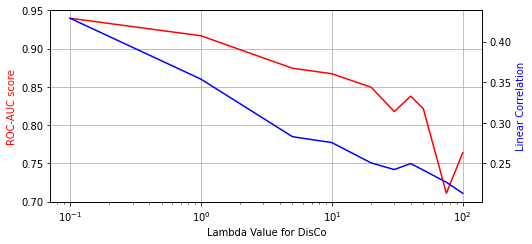

In [17]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
ax1 = plt.subplot()
l1, = ax1.plot(lambda_list, AUC_list, color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(lambda_list, corr_list, color='blue')

ax1.set_ylabel('ROC-AUC score', color='red')
ax2.set_ylabel('Linear Correlation', color='blue')
ax1.set_xlabel("Lambda Value for DisCo")
ax1.set_xscale('log')
ax1.grid()
plt.savefig('Lambda_Compare/Summary_Plots.pdf')